In [1]:
import funs
import funs.model as model

import torch
import os

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import transforms

import pandas as pd 
import numpy as np  

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = funs.load_yaml('./config.yaml')

funs.set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


In [3]:
model_name = 'FRFconv-TDS_test'
log_file = 'log_per_acc_test.txt'
cm_name = 'confusion_matrix_test.png'

In [4]:
data_root_dirs = os.path.join(config.dataset_root)

Cylindrical_dirs = funs.get_bearing_paths(data_root_dirs, 'CylindricalRoller', config.rpm)
DepGroove_dirs = funs.get_bearing_paths(data_root_dirs, 'DeepGrooveBall', config.rpm)
Tapered_dirs = funs.get_bearing_paths(data_root_dirs, 'TaperedRoller', config.rpm)

In [5]:
print("Making dataframes...")

Cylindrical_df = funs.make_dataframe(config, Cylindrical_dirs)
DepGroove_df =funs.make_dataframe(config, DepGroove_dirs)
Tapered_df = funs.make_dataframe(config, Tapered_dirs)

Making dataframes...


In [7]:
print("concat dataframes...")

all_df = pd.concat([Cylindrical_df, DepGroove_df, Tapered_df], ignore_index=True)

concat dataframes...


In [8]:
train_df, val_df, test_df = funs.split_dataframe(all_df, 0.6, 0.2)

train_data, train_label = funs.build_from_dataframe(train_df, config.sample_size, config.overlap, False)
val_data, val_label = funs.build_from_dataframe(val_df, config.sample_size, config.overlap, False)
test_data, test_label = funs.build_from_dataframe(test_df, config.sample_size, config.overlap, False)

In [9]:
# np -> tensor transform
tf_data = transforms.Compose([funs.processing.NpToTensor(), funs.processing.ToSignal()])
tf_label = transforms.Compose([funs.processing.NpToTensor()])

In [10]:
train_dataset = funs.NumpyDataset(train_data, train_label, transform=tf_data, target_transform=tf_label)
val_dataset = funs.NumpyDataset(val_data, val_label, transform=tf_data, target_transform=tf_label)
test_dataset = funs.NumpyDataset(test_data, test_label, transform=tf_data, target_transform=tf_label)

train_loader = funs.get_dataloader(train_dataset, config.batch_size, True)
val_loader = funs.get_dataloader(val_dataset, config.batch_size, False)
test_loader = funs.get_dataloader(test_dataset, config.batch_size, False)

In [11]:
n_classes = all_df["label"].max() - all_df["label"].min() + 1
model = model.Mynet2(n_classes=n_classes).to(device)

In [12]:
optimizer = Adam(model.parameters(), lr = float(config.learning_rate))
loss = CrossEntropyLoss()

In [13]:
trainer = funs.Trainer(model, loss, optimizer, device, train_loader, val_loader)
train_loss, val_loss = trainer.train(config.epoch)
trainer.save(config.model_root, model_name)

model_path = f'{config.model_root}/{model_name}.pt'
trainer.model.load_state_dict(torch.load(model_path, weights_only=True))

fault_label_list, val_loss, predicted_label_list = trainer.eval() 


Starting Training... 
----------------------------------------
[EPOCH: 0] 
Train Loss: 1.22983
Train Acc: 0.47487


Starting Evaluation... 
----------------------------------------
Validation Loss: 1.09753
[EPOCH: 1] 
Train Loss: 0.55648
Train Acc: 0.74534


Starting Evaluation... 
----------------------------------------
Validation Loss: 0.38840

Starting Evaluation... 
----------------------------------------
Validation Loss: 0.38840


Class-wise Accuracy:
Class 0: 0.93952
Class 1: 0.98432
Class 2: 0.99462
Class 3: 0.45923
Class 4: 0.77016
Class-wise accuracy logged to log_per_acc_test.txt


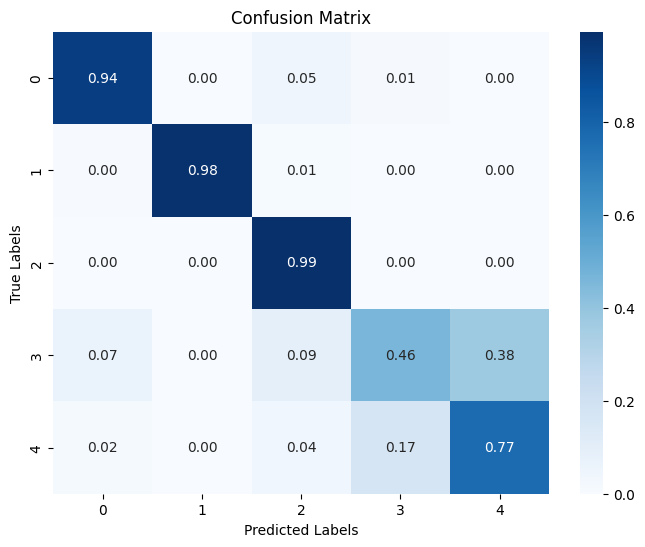

In [14]:
# acc per class logging
funs.log_class_acc(config.log_root, fault_label_list, predicted_label_list, f'{log_file}')

# confusion matrix plot
funs.plot_confusion_matrix(config.pic_root ,fault_label_list, predicted_label_list, cm_name)